# General Settings

In [1]:
SETTING_RETRAIN_CLASSIFIER = False         # Change this to retrain the classifier
SETTING_SAVE_RETRAINED_CLASSIFIER = True   # Change this to save the retrained classifier (if retraining)
SETTING_LOAD_TRAINED_CLASSIFIER = True     # Change this in case SETTING_SAVE_RETRAINED_CLASSIFIER and you want to use the freshly trained classifier without overwriting the one on disc
SETTING_TEST_CLASSIFIER_ON_TEST_IMAGES = False  # Change this to show how the classifier works on test images

# Imports

## Note: Uses OpenCV 3.2 with Contrib (pip install opencv-contrib-python)

In [2]:
# SKLearn
import sklearn
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC 
from sklearn import svm
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# MatPlotLib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# The rest
import numpy as np
from scipy.ndimage.measurements import label
import cv2
from glob import glob
import random
import csv
import time
import os


/Users/rbaron/miniconda3/envs/carnd-term1b/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/rbaron/miniconda3/envs/carnd-term1b/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# Define Feature Extraction Pipeline

In [3]:
def convert_color(img, color_space='LUV'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)
    return feature_image   

def get_hog_features(img, 
                     orient,
                     pix_per_cell, 
                     cell_per_block,
                     vis=False, 
                     feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size, interpolation=cv2.INTER_LINEAR).ravel()
    color2 = cv2.resize(img[:,:,1], size, interpolation=cv2.INTER_LINEAR).ravel()
    color3 = cv2.resize(img[:,:,2], size, interpolation=cv2.INTER_LINEAR).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 256)):    #
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [4]:
IMG_SHAPE = (64, 64)

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (48, 48) # Spatial binning dimensions
hist_bins = 64    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [5]:
def extract_features(img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat):   
    img_resize = cv2.resize(img, spatial_size, interpolation=cv2.INTER_LINEAR)
    img_resize = (np.sqrt(img_resize.astype(np.float32)/255)*255).astype(np.uint8)    
    file_features = []   
    feature_image = convert_color(img_resize, color_space=color_space)
    file_features.append(feature_image.ravel())
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block)
        # Append the new feature vector to the features list
    file_features.append(hog_features)   
    #  print(len(file_features), len(spatial_features), len(hist_features), len(hog_features)) 
    return np.concatenate(file_features)

# Load training data for the classifier

In [6]:
if SETTING_RETRAIN_CLASSIFIER == True:
    # total_imgs = 0
    SAMPLES_TO_USE = 8000

    vehicle_fnames = glob('dataset/vehicles/*/*.png')
    non_vehicle_fnames = glob('dataset/non-vehicles/*/*.png')

    vehicle_fnames = random.sample(vehicle_fnames, SAMPLES_TO_USE)
    non_vehicle_fnames = random.sample(non_vehicle_fnames, SAMPLES_TO_USE)

    print("Sampling complete, loading images")

    car_images = [mpimg.imread(fname) for fname in vehicle_fnames]
    non_car_images = [mpimg.imread(fname) for fname in non_vehicle_fnames]

    # Normalize
    car_images = [(image.astype(np.float32)/np.max(image)*255).astype(np.uint8) for image in car_images]
    non_car_images = [(image.astype(np.float32)/np.max(image)*255).astype(np.uint8) for image in non_car_images]

    print("Loading complete, extracting features")

    car_features = [extract_features(image) for image in car_images]
    non_car_features = [extract_features(image) for image in non_car_images]

    print("Extracting complete")

    X_cars = np.vstack(car_features)
    y_cars = np.ones(X_cars.shape[0], dtype=np.uint8)
    X_non_cars = np.vstack(non_car_features)
    y_non_cars = np.zeros(X_non_cars.shape[0], dtype=np.uint8)

    X = np.vstack((X_cars, X_non_cars))
    y = np.concatenate((y_cars, y_non_cars))


# Normalize training data

In [7]:
if SETTING_RETRAIN_CLASSIFIER == True:
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    print('{} cars labeled & {} non-cars labeled'.format(len(X_cars), len(X_non_cars)))
    del X_cars
    del X_non_cars

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Train the classifier

## Search parameters

In [8]:
# After trying an (nearly) infite number of kernels via grid search... I  settle on the best performing one
SEARCH_C_VALUES=[0.0001]
SEARCH_KERNEL_VALUES=['linear'] 
SEARCH_GAMMA_VALUES=[0.00001]
parameters = {'kernel': SEARCH_KERNEL_VALUES, 'C': SEARCH_C_VALUES, 'gamma': SEARCH_GAMMA_VALUES}

## Grid search (commented out because we have a good parameter combination now)

In [9]:
# def optimize_param(parameters):
#     svc = GridSearchCV(svm.SVC(), parameters)
#     # Check the training time for the SVC
#     t=time.time()
#     svc.fit(X_train, y_train)
#     t2 = time.time()
#     print(round(t2-t, 2), 'Seconds to train SVC...')
#     optimal_params = svc.best_params_
#     print("Optimal parameters found: ", optimal_params, "\n")
#     # Check the score of the SVC
#     test_score = round(svc.score(X_test, y_test), 4)
#     print('Test Accuracy of SVC = ', test_score)
#     # Check the prediction time for a single sample
#     t=time.time()

## Final training

In [10]:
if SETTING_RETRAIN_CLASSIFIER == True:
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

    svca = LinearSVC(C=0.0001, dual=False, max_iter=5)


    Batch_size = len(X_train)//5
    print('training on {} samples, {} batches, each batch {} samples'.format(len(X_train), len(X_train)//Batch_size, Batch_size))

    for batch in range(0,len(X_train)//Batch_size):
    # for batch in range(0,2):
        t=time.time()
        svca.fit(X_train[batch*Batch_size:(batch+1)*Batch_size], y_train[batch*Batch_size:(batch+1)*Batch_size])
        t2 = time.time()
        print('batch:', batch+1,'-', round(t2-t, 2), 'Seconds to train SVC...')

        # Check the score of the SVC
        test_score = round(svca.score(X_test, y_test), 4)
        print('Test Accuracy of SVC = ', test_score)
        # Check the prediction time for a single sample
        t=time.time()
    print ('done')

## Print statistics

In [11]:
if SETTING_RETRAIN_CLASSIFIER == True:
    predict = svca.predict(X_test)

    def print_stats(labels, predict):
        print(labels[:20])
        print(predict[:20])
        cm = confusion_matrix(labels, predict)
        tot = cm.sum()
        TN = cm[0][0]/tot
        FP = cm[0][1]/tot
        FN = cm[1][0]/tot
        TP = cm[1][1]/tot
        print("%s %.2f%% %s %.2f%% %s %.2f%% %s %.2f%%\n" % ('TP:',TP, 'FP:',FP, 'TN:',TN, 'FN:',FN))   
        print(classification_report(labels, predict))

    print_stats(y_test, predict)

# Save the classifier if we're happy with it

In [12]:
CLASSIFIER_SAVE_PATH = 'intermediates/car_classifier.pkl'
SCALER_SAVE_PATH = 'intermediates/car_scaler.pkl'

if SETTING_SAVE_RETRAINED_CLASSIFIER == True and SETTING_RETRAIN_CLASSIFIER == True:
    joblib.dump(svca, CLASSIFIER_SAVE_PATH)
    joblib.dump(X_scaler, SCALER_SAVE_PATH)

# Load the saved classifier

In [13]:
SETTING_LOAD_TRAINED_CLASSIFIER = True
CLASSIFIER_LOAD_PATH = 'intermediates/car_classifier.pkl'
SCALER_LOAD_PATH = 'intermediates/car_scaler.pkl'
if SETTING_LOAD_TRAINED_CLASSIFIER == True:
    svc = None
    svc = joblib.load(CLASSIFIER_LOAD_PATH)
    if svc != None:
        print('Classifier loaded successfully:')
        print(svc)
    X_scaler = joblib.load(SCALER_LOAD_PATH)
    if X_scaler != None:
        print('Scaler loaded successfully:')
        print(X_scaler)

Classifier loaded successfully:
LinearSVC(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=5,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Scaler loaded successfully:
StandardScaler(copy=True, with_mean=True, with_std=True)


/Users/rbaron/miniconda3/envs/carnd-term1b/lib/python3.5/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/rbaron/miniconda3/envs/carnd-term1b/lib/python3.5/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Define the window search and conversion to bounding boxes

In [27]:
# WINDOW_SEARCH_RANGES = [
# #      {'window_size': (256,256), 'x_start_stop': [None, None], 'y_start_stop': [360, 740], 'xy_overlap':(0.8, 0.8)},
#      {'window_size': (192,192), 'x_start_stop': [None, None], 'y_start_stop': [360, 740], 'xy_overlap':(0.8, 0.8)},
#      {'window_size': (128,128), 'x_start_stop': [50, 1300], 'y_start_stop': [360, 600], 'xy_overlap':(0.8, 0.8)},
#      {'window_size': (64,64), 'x_start_stop': [200, 1200], 'y_start_stop': [360, 500], 'xy_overlap':(0.85, 0.85)},
# ]

WINDOW_SEARCH_RANGES = [
#      {'window_size': (256,256), 'x_start_stop': [None, None], 'y_start_stop': [360, 740], 'xy_overlap':(0.8, 0.8)},
     {'window_size': (192,192), 'x_start_stop': [None, None], 'y_start_stop': [360, 740], 'xy_overlap':(0.8, 0.8)},
     {'window_size': (160,160), 'x_start_stop': [None, None], 'y_start_stop': [360, 740], 'xy_overlap':(0.8, 0.8)},
     {'window_size': (128,128), 'x_start_stop': [None, None], 'y_start_stop': [360, 700], 'xy_overlap':(0.8, 0.8)},
     {'window_size': (96,96), 'x_start_stop': [200, 1200], 'y_start_stop': [360, 550], 'xy_overlap':(0.8, 0.8)},
     {'window_size': (64,64), 'x_start_stop': [200, 1200], 'y_start_stop': [360, 500], 'xy_overlap':(0.8, 0.8)},
]

def search_windows(img, windows, clf, scaler, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        if window[1][1] < 0 or window[1][0] < 0 or window[0][1] < 0 or window[0][0] < 0:
            continue

        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], IMG_SHAPE)

        
        #4) Extract features for that window using single_img_features()
        features = extract_features(test_img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=4):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def heatmap_from_positives(image, positive_windows):
    heatmap = np.zeros(image.shape[0:2])
    for window in positive_windows:
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return heatmap

def get_all_windows(image):
    all_windows = []
    for search_range in WINDOW_SEARCH_RANGES:
        windows = slide_window(image, 
                               xy_window=search_range['window_size'],
                               x_start_stop=search_range['x_start_stop'], 
                               y_start_stop=search_range['y_start_stop'], 
                               xy_overlap=search_range['xy_overlap'])
        all_windows.extend(windows)
    return all_windows

# def get_var_windows(window_sizes):
#     ret_windows = []
#     for size in window_sizes:
#         ret_windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(size, size), xy_overlap=search_windows_overlap))
#     return ret_windows

def get_labeled_bboxes(labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    return bboxes

def get_bbox_center(bbox):
    x = (bbox[1][0] - bbox[0][0])/2 + bbox[0][0]
    y = (bbox[1][1] - bbox[0][1])/2 + bbox[0][1]
    return (int(x),int(y))

# test_bb = ((100, 500), (300, 700))
# test = get_bbox_center(test_bb)
# print(test)

# Visualize the search area

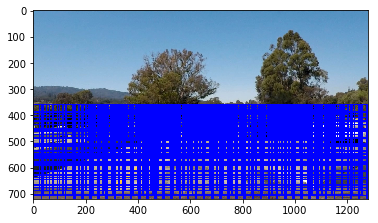

In [28]:
def visualize_search_area():
    # Load an image
    files = glob('test_images/test*.jpg')
    image = mpimg.imread(files[0])

    # Get all windows (get_all_windows)
    windows = get_all_windows(image)
    
    # Draw the boxes (draw_boxes)
    image = draw_boxes(image, windows)
    
    plt.imshow(image)

visualize_search_area()

# Try classifier on provided test images

In [29]:
DETECTION_THRESHOLD = 4

if SETTING_TEST_CLASSIFIER_ON_TEST_IMAGES:
    files = glob('test_images/test*.jpg')
    for file in files:
        image = mpimg.imread(file)
        draw_image = np.copy(image)

        windows = get_all_windows(image)
        
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)                       


        all_windows_img = draw_boxes(draw_image, windows)
        positive_labeled_windows = draw_boxes(draw_image, hot_windows)

        heatmap = heatmap_from_positives(image, hot_windows)
        heatmap_orig = np.copy(heatmap)
        # Threshold
        heatmap[heatmap <= DETECTION_THRESHOLD] = 0
        # Label separate detections
        labels = label(heatmap)
        # Calculate bounding boxes for labels
        detected_bboxes = get_labeled_bboxes(labels)
        # Draw bounding boxes on image
        if detected_bboxes is not None:
            img_with_bboxes = draw_boxes(image, detected_bboxes)
        else: 
            img_with_bboxes = image

        # Plot
        f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 10))
        f.tight_layout()
        ax1.set_title('Scanned Windows', fontsize=30)
        ax1.imshow(all_windows_img)
        ax2.set_title('Positive Scans', fontsize=30)
        ax2.imshow(positive_labeled_windows)
        ax3.set_title('Heatmap before threshold', fontsize=30)
        ax3.imshow(heatmap_orig, cmap='gray')
        ax4.set_title('Heatmap after threshold', fontsize=30)
        ax4.imshow(heatmap, cmap='hot')
        ax5.set_title('Labels', fontsize=30)
        ax5.imshow(labels[0], cmap='gray')
        ax6.set_title('Final Detections', fontsize=30)
        ax6.imshow(img_with_bboxes)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.1, hspace=0.2)
        plt.show()

# Settings for Video Processing

In [30]:
TEST_VIDEO_INPUT_PATH = 'test_video.mp4'
TEST_VIDEO_OUTPUT_PATH = 'output_images/test_video_output.mov'

PROJECT_VIDEO_INPUT_PATH = 'project_video.mp4'
PROJECT_VIDEO_OUTPUT_PATH = 'output_images/project_video_output.mov'

FRAMES_BETWEEN_FULL_SEARCHES = 10  
OVERLAP_THRESHOLD = 0.5
MIN_DETECTIONS_FOR_QUALITY_TRACKER = 5
MIN_DETECTIONS_FOR_TRACKER = 4

# NEARBY_WINDOW_OVERLAP_HORIZ = 0.95
# NEARBY_WINDOW_OVERLAP_VERT = 0.98
# NEARBY_WINDOW_STEPS_PER_DIRECTION = 2
# NEARBY_WINDOW_SCALEDOWN = 0.98

# Use the classifier on the video

In [31]:

def detect_cars_in_frame(image, windows):
    hot_windows = search_windows(image, 
                                 windows, 
                                 svc, 
                                 X_scaler, 
                                 color_space=color_space, 
                                 spatial_size=spatial_size, 
                                 hist_bins=hist_bins, 
                                 orient=orient, 
                                 pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, 
                                 spatial_feat=spatial_feat, 
                                 hist_feat=hist_feat,
                                 hog_feat=hog_feat)                       

    heatmap = heatmap_from_positives(image, hot_windows)
    # Threshold
    heatmap[heatmap <= DETECTION_THRESHOLD] = 0
    # Label separate detections
    labels = label(heatmap)
    # Calculate bounding boxes for labels
    detected_bboxes = get_labeled_bboxes(labels)
    
    return detected_bboxes

from common_geometry import Rect, Point


class VehicleTracker():
    
    def __init__(self, stable_id, initial_frame, initial_rect):
        self.detect_rects_history = []
        self.stable_id = stable_id
        self.tracker = cv2.Tracker_create("KCF")
        tracker_bbox = (initial_rect.get_left(), 
                        initial_rect.get_top(),
                        initial_rect.get_width(),
                        initial_rect.get_height())
        self.tracker.init(initial_frame, tracker_bbox)
        self.detect_rects_history.append(initial_rect)
        self.has_been_updated = False
        self.is_lost = False
        self.is_rejected = False

        
    def update(self, frame):
        res, bbox = self.tracker.update(frame)
        if not res:
            self.is_lost = True
            return None
        rect = Rect(
            Point(bbox[0], bbox[1]), 
            Point(bbox[0]+bbox[2], bbox[1]+bbox[3]))
        if rect.get_height() == 0 or rect.get_width() == 0:
            self.is_lost = True
            return None
        
        # Check if classifier agrees. Weed out false positives this way.
        classify_bbox = ((rect.p1.x, rect.p1.y), (rect.p2.x, rect.p2.y))
        windows = []
        windows.append(classify_bbox)
        hot_windows = search_windows(frame, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)  
        
        if len(hot_windows) > 0:
            # Classifier approved
            self.detect_rects_history.append(rect)
            self.has_been_updated = True
            return rect
        else:
            # Classifier rejected. Disable this tracker
            # TODO: Add rejection threshold?
            self.is_rejected = True
            return None
        
    def readjust_area(self, frame, rect):
        self.tracker = cv2.Tracker_create("KCF")
        tracker_bbox = (rect.get_left(), 
                        rect.get_top(),
                        rect.get_width(),
                        rect.get_height())
        self.tracker.init(frame, tracker_bbox)
    
    def get_stable_id(self):
        return self.stable_id
    
    def get_is_lost_or_rejected(self):
        return (self.is_lost or self.is_rejected)
    
    def get_latest_detection(self):
        return self.detect_rects_history[-1]
        
    def get_detected_rects_history(self):
        return self.detect_rects_history
    
    def get_has_been_updated(self):
        return self.has_been_updated





def process_video(video_input_path, video_output_path):
    if os.path.exists(video_output_path):
        os.remove(video_output_path)
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    video_out = cv2.VideoWriter(video_output_path, 
                                fourcc, 
                                fps=20.0, 
                                frameSize=(1280,720), 
                                isColor=True)        

    video = cv2.VideoCapture(video_input_path)

    has_reached_end = False
    previous_batch_detections = None
    full_scan_windows = None
    frame_idx = 0
    trackers = []
    historical_lost_trackers = []
    vehicles_counter = 0
    too_many_lost_trackers = False
    while(video.isOpened() and not has_reached_end):
        time_op_start = time.time()

        # Read a frame, make sure we're not at the end
        ret, frame = video.read()
        if ret == False:
            has_reached_end = True
            break

        # Get the full scan windows for the first time if needed
        if full_scan_windows is None:
            full_scan_windows = get_all_windows(frame)

        # For FRAMES_BETWEEN_FULL_SEARCHES frames, do full detection. 
        # Otherwise, just continue detecting using the trackers
        frame_detections = []
        if (frame_idx % FRAMES_BETWEEN_FULL_SEARCHES == 0) or too_many_lost_trackers:
            print("Full scan")
            too_many_lost_trackers = False
            frame_detections = detect_cars_in_frame(
                frame,
                full_scan_windows
            )

            for detection in frame_detections:
                rect = Rect(
                    Point(detection[0][0], detection[0][1]),
                    Point(detection[1][0], detection[1][1]))
                if rect.get_height() == 0 or rect.get_width() == 0:
                    continue
                current_detection_area = rect.calculate_area()

                # Check if there is overlap with an existing tracker
                overlapping_tracker_found = False
                for tracker in trackers:
                    if tracker.get_is_lost_or_rejected() == True:
                        continue
                    latest_detection = tracker.get_latest_detection()
                    overlap = latest_detection.calculate_overlap(rect)
                    if overlap == None:
                        continue
                    overlap_area = overlap.calculate_area()
                    if overlap_area/current_detection_area >= OVERLAP_THRESHOLD:
                        # Found an overlapping tracker, no need to record this detection
                        tracker.readjust_area(frame, rect)
                        overlapping_tracker_found = True
                        break
                    elif overlap_area/latest_detection.calculate_area() >= OVERLAP_THRESHOLD:
                        # Overlap is large in comparison to previous detected area
                        # TODO: Consider switching to the larger area
                        tracker.readjust_area(frame, rect)
                        overlapping_tracker_found = True
                        break   
                # No need to create a new tracker if the full scan window overlaps with an existing tracker
                if overlapping_tracker_found == True:
                    continue

                vehicles_counter += 1
                tracker = VehicleTracker(vehicles_counter, frame, rect)
                print("Tracker id {} INIT rect {}".format(tracker.get_stable_id(), rect))
                trackers.append(tracker)

        # We count on the trackers to provide us with detections
        # We validate detections against our own classifier
        # If the classifier rejects the detection, 
        frame_detections = []
        for tracker in trackers:
    #         # Skip updating trackers which were just initialized and never have been updated yet
    #         rect = None
    #         if tracker.get_has_been_updated():
    #             rect = tracker.update(frame)
    #         else:
            rect = tracker.update(frame)
            if rect is not None:
    #             print("Tracker {} FIND bbox: {}".format(tracker.get_stable_id(), rect))
                bbox = ((rect.p1.x, rect.p1.y), (rect.p2.x, rect.p2.y))
                
                # Only treat tracker seriously after it gained MIN_DETECTIONS_FOR_TRACKER
                # Assume that the tracker is gaining first detections
                if len(tracker.get_detected_rects_history()) >= MIN_DETECTIONS_FOR_TRACKER:
                    frame_detections.append(bbox)
            else:
                print("Tracker {} LOST or REJECTED".format(tracker.get_stable_id()))

        # Move lost trackers to historical_lost_trackers
        lost_trackers = [tracker for tracker in trackers if tracker.get_is_lost_or_rejected()]
        historical_lost_trackers.extend(lost_trackers)
        trackers = [tracker for tracker in trackers if not tracker.get_is_lost_or_rejected()]

        # TODO: Go over each tracker, if there are more than 2 recent detections, draw the ID on the car
        
        # TODO: For lost trackers which had enough detections, we want to run nearby classifier search, to attempt a reacquire
        # Until then, we just run a full search on next frame if a high quality tracker was just lost
        quality_lost_trackers = [tracker for tracker in lost_trackers if len(tracker.get_detected_rects_history()) >= MIN_DETECTIONS_FOR_QUALITY_TRACKER ]
        if len(quality_lost_trackers) > 0:
            too_many_lost_trackers = True
        
        frame_idx += 1
        out_frame = draw_boxes(frame, frame_detections)
        video_out.write(out_frame)

        # TODO: 
        # 1. (2d) velocity and (2d) direction calculation. Can later be used for 3d calculation by transform to horizon



        # Original pipeline time per frame was 9 seconds on my laptop.
        # To build a real-time pipeline we need 2 orders of magnitute improvement (<16ms for 60fps)
        time_op_end = time.time()
    #     print('Time per frame: {}', (time_op_end - time_op_start))



    print("Releasing everything")
    video.release()
    video_out.release()
    # cv2.destroyAllWindows() ro

# Process test or project video
# process_video(TEST_VIDEO_INPUT_PATH, TEST_VIDEO_OUTPUT_PATH)
process_video(PROJECT_VIDEO_INPUT_PATH, PROJECT_VIDEO_OUTPUT_PATH)

Full scan


/Users/rbaron/miniconda3/envs/carnd-term1b/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Tracker id 1 INIT rect Rect(Point(31,360),Point(283,551))
Full scan
Tracker 1 LOST or REJECTED
Full scan
Full scan
Tracker id 2 INIT rect Rect(Point(114,360),Point(190,519))
Tracker id 3 INIT rect Rect(Point(961,384),Point(1089,512))
Tracker id 4 INIT rect Rect(Point(1093,398),Point(1103,447))
Tracker 2 LOST or REJECTED
Tracker 3 LOST or REJECTED
Tracker 4 LOST or REJECTED
Full scan
Tracker id 5 INIT rect Rect(Point(93,360),Point(311,519))
Tracker id 6 INIT rect Rect(Point(1054,360),Point(1188,519))
Tracker 6 LOST or REJECTED
Full scan
Tracker 5 LOST or REJECTED
Full scan
Full scan
Tracker id 7 INIT rect Rect(Point(150,360),Point(295,519))
Full scan
Full scan
Tracker 7 LOST or REJECTED
Full scan
Tracker id 8 INIT rect Rect(Point(76,360),Point(190,519))
Tracker 8 LOST or REJECTED
Full scan
Tracker id 9 INIT rect Rect(Point(155,391),Point(159,519))
Tracker 9 LOST or REJECTED
Full scan
Tracker id 10 INIT rect Rect(Point(124,360),Point(252,519))
Tracker 10 LOST or REJECTED
Full scan
Tracke

Tracker id 88 INIT rect Rect(Point(896,360),Point(1217,550))
Tracker id 89 INIT rect Rect(Point(50,410),Point(191,537))
Tracker id 90 INIT rect Rect(Point(250,410),Point(252,447))
Tracker id 91 INIT rect Rect(Point(257,417),Point(311,455))
Tracker 88 LOST or REJECTED
Tracker 90 LOST or REJECTED
Tracker 91 LOST or REJECTED
Tracker 89 LOST or REJECTED
Full scan
Tracker id 92 INIT rect Rect(Point(884,360),Point(1227,519))
Tracker id 93 INIT rect Rect(Point(236,410),Point(333,512))
Tracker 92 LOST or REJECTED
Tracker 93 LOST or REJECTED
Full scan
Tracker id 94 INIT rect Rect(Point(884,360),Point(1202,550))
Tracker id 95 INIT rect Rect(Point(200,384),Point(335,537))
Tracker id 96 INIT rect Rect(Point(93,422),Point(191,537))
Tracker 94 LOST or REJECTED
Tracker 95 LOST or REJECTED
Tracker 96 LOST or REJECTED
Full scan
Tracker id 97 INIT rect Rect(Point(908,360),Point(1188,512))
Tracker id 98 INIT rect Rect(Point(50,410),Point(327,562))
Tracker 97 LOST or REJECTED
Full scan
Tracker id 99 INIT 

Full scan
Tracker id 175 INIT rect Rect(Point(257,360),Point(323,423))
Tracker 173 LOST or REJECTED
Full scan
Full scan
Tracker id 176 INIT rect Rect(Point(260,417),Point(263,423))
Tracker 176 LOST or REJECTED
Full scan
Tracker id 177 INIT rect Rect(Point(356,372),Point(359,423))
Tracker id 178 INIT rect Rect(Point(296,420),Point(323,435))
Tracker 178 LOST or REJECTED
Tracker 177 LOST or REJECTED
Tracker 175 LOST or REJECTED
Full scan
Tracker id 179 INIT rect Rect(Point(320,422),Point(345,423))
Tracker id 180 INIT rect Rect(Point(200,455),Point(295,512))
Tracker 179 LOST or REJECTED
Tracker 180 LOST or REJECTED
Full scan
Tracker id 181 INIT rect Rect(Point(296,372),Point(323,423))
Tracker 181 LOST or REJECTED
Full scan
Tracker id 182 INIT rect Rect(Point(279,372),Point(419,483))
Tracker 182 LOST or REJECTED
Full scan
Tracker id 183 INIT rect Rect(Point(38,391),Point(287,550))
Tracker id 184 INIT rect Rect(Point(308,398),Point(428,493))
Tracker id 185 INIT rect Rect(Point(296,420),Point

Tracker 254 LOST or REJECTED
Full scan
Tracker id 260 INIT rect Rect(Point(824,360),Point(1213,550))
Tracker id 261 INIT rect Rect(Point(50,372),Point(395,550))
Tracker id 262 INIT rect Rect(Point(404,398),Point(542,493))
Tracker 261 LOST or REJECTED
Full scan
Tracker 262 LOST or REJECTED
Full scan
Tracker id 263 INIT rect Rect(Point(25,360),Point(527,550))
Tracker id 264 INIT rect Rect(Point(992,360),Point(1227,551))
Tracker 263 LOST or REJECTED
Full scan
Tracker id 265 INIT rect Rect(Point(464,360),Point(761,581))
Tracker id 266 INIT rect Rect(Point(31,398),Point(438,612))
Tracker id 267 INIT rect Rect(Point(440,410),Point(457,423))
Tracker 265 LOST or REJECTED
Tracker 267 LOST or REJECTED
Tracker 266 LOST or REJECTED
Full scan
Tracker id 268 INIT rect Rect(Point(476,372),Point(551,423))
Tracker id 269 INIT rect Rect(Point(296,398),Point(457,550))
Tracker id 270 INIT rect Rect(Point(464,398),Point(466,423))
Tracker id 271 INIT rect Rect(Point(558,422),Point(563,423))
Tracker id 272 I

Tracker 348 LOST or REJECTED
Full scan
Tracker id 349 INIT rect Rect(Point(1093,384),Point(1187,455))
Tracker id 350 INIT rect Rect(Point(1075,420),Point(1079,483))
Tracker id 351 INIT rect Rect(Point(1088,420),Point(1091,447))
Tracker 350 LOST or REJECTED
Tracker 351 LOST or REJECTED
Tracker 349 LOST or REJECTED
Full scan
Tracker id 352 INIT rect Rect(Point(1076,384),Point(1187,495))
Tracker 352 LOST or REJECTED
Full scan
Tracker id 353 INIT rect Rect(Point(1100,432),Point(1175,495))
Tracker 353 LOST or REJECTED
Full scan
Tracker id 354 INIT rect Rect(Point(1116,408),Point(1187,495))
Tracker 354 LOST or REJECTED
Full scan
Tracker id 355 INIT rect Rect(Point(1112,396),Point(1175,459))
Tracker 355 LOST or REJECTED
Full scan
Tracker id 356 INIT rect Rect(Point(1125,391),Point(1244,512))
Tracker id 357 INIT rect Rect(Point(1093,417),Point(1115,423))
Tracker id 358 INIT rect Rect(Point(1085,420),Point(1091,423))
Tracker 357 LOST or REJECTED
Tracker 358 LOST or REJECTED
Full scan
Tracker id